In [192]:
import pandas as pd
from src import *
import matplotlib.pyplot as plt
from string import punctuation
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split , cross_validate , GridSearchCV, cross_val_predict
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, plot_confusion_matrix
from nltk.corpus import stopwords as sw
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import  word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
pd.set_option ('display.max_colwidth', None)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def mean_scores(results):
    '''Return Train/Test Mean Score from a Cross Val'''
    return print(f'''Mean Train Score: {results['train_score'].mean()}
Mean Test Score: {results['test_score'].mean()}''')

def metrics(y_true,y_preds):
    '''Gives recall,precision,accuracy,F1 score and confusion matrix'''
    return print(f'''Recall Score: {recall_score(y_true,y_preds,average='micro')}
Precision Score: {precision_score(y_true,y_preds,average='micro')}
Accuracy Score:{accuracy_score(y_true,y_preds)}
F1 Score: {f1_score(y_true,y_preds,average='micro')}
Confusion Matrix: 
{confusion_matrix(y_true,y_preds)}''')

def gs_mean_scores(results):
    '''Return Train and Test Scores from a grid search'''
    return print(f'''Mean Train Score: {results.cv_results_['mean_train_score'].mean()}'
Mean Test Score: {results.cv_results_['mean_test_score'].mean()}''')

def company_search(test):
    if test == 'iphone':
        return 'apple'
    elif test == 'apple':
        return 'apple'
    elif test == 'ipad':
        return 'apple'
    elif test == 'ipad or iphone app':
        return 'apple'
    elif test == 'itunes':
        return 'apple'
    elif test == 'other apple product or service':
        return 'apple'
    elif test == 'ios':
        return 'apple'
    elif test == 'ipadquot':
        return 'apple'
    elif test == 'applequot':
        return 'apple'
    elif test == 'iphonequot':
        return 'apple'
    elif test == 'quotiphone':
        return 'apple'
    elif test == 'iosquot':
        return 'apple'
    elif test =='quotipad':
        return 'apple'
    elif test == 'quotapple':
        return 'apple'
    elif test =='google':
        return 'google'
    elif test == 'android':
        return 'google'
    elif test == 'other google product or service':
        return 'google'
    elif test == 'android app':
        return 'google'
    elif test == 'quotgoogle':
        return 'google'
    elif test == 'googlequot':
        return 'google'
    elif test == 'androidquot':
        return 'google'
    else:
        return 'unknown'

In [3]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',encoding='latin1')
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

There are 5802 missing values telling what the tweet is directed at. A way to combat this would be to look at the tweet and look for keywords such as iphone or ipad and assign who it is directed to that way.

In [4]:
df = df.dropna(subset=['tweet_text'])

In [5]:
tweets = TweetTokenizer(preserve_case=False,reduce_len=True)
tweet = df.copy()
tweet['tweet_text'] = tweet['tweet_text'].str.replace(r'[^\w\s]', '')
tweet['tweet_text'] = tweet['tweet_text'].str.replace('ÏÏàü_ÊÎÒÁââ_â_ÛâRT','')
tweet['tweet_text'].apply(tweets.tokenize)

0                        [wesley, 83, i, have, a, 3g, iphone, after, 3, hrs, tweeting, at, rise_austin, it, was, dead, i, need, to, upgrade, plugin, stations, at, sxsw]
1                [jessedee, know, about, fludapp, awesome, ipadiphone, app, that, youll, likely, appreciate, for, its, design, also, theyre, giving, free, ts, at, sxsw]
2                                                                             [swonderlin, can, not, wait, for, ipad, 2, also, they, should, sale, them, down, at, sxsw]
3                                                                           [sxsw, i, hope, this, years, festival, isnt, as, crashy, as, this, years, iphone, app, sxsw]
4                                [sxtxstate, great, stuff, on, fri, sxsw, marissa, mayer, google, tim, oreilly, tech, booksconferences, amp, matt, mullenweg, wordpress]
                                                                                      ...                                                                  

In [6]:
tweet['tweet_text'] = tweet['tweet_text'].str.strip('ÏÏàü_ÊÎÒÁââ_â_ÛâRTÛÏ')
tweet['tweet_text'] = tweet['tweet_text'].str.strip('Û')

In [7]:
tweet['tweet_text']

0                          wesley83 I have a 3G iPhone After 3 hrs tweeting at RISE_Austin it was dead  I need to upgrade Plugin stations at SXSW
1              jessedee Know about fludapp  Awesome iPadiPhone app that youll likely appreciate for its design Also theyre giving free Ts at SXSW
2                                                                      swonderlin Can not wait for iPad 2 also They should sale them down at SXSW
3                                                                    sxsw I hope this years festival isnt as crashy as this years iPhone app sxsw
4                           sxtxstate great stuff on Fri SXSW Marissa Mayer Google Tim OReilly tech booksconferences amp Matt Mullenweg Wordpress
                                                                          ...                                                                    
9088                                                                                                                    Ipad

In [8]:
snbstem = SnowballStemmer('english')
tweet['tweet_text'] = tweet['tweet_text'].apply(lambda x: [snbstem.stem(x)])
tweet['tweet_text'] = tweet['tweet_text'].str.join(' ')


In [10]:
#Take out puncuation and other unnecessary characters
df['tweet_text'] = df['tweet_text'].str.replace(r'[^\w\s]', '')
df['tweet_text'] = df['tweet_text'].str.replace('quot', '')
# Make lower case and split
df['tweet_text'] = df['tweet_text'].str.lower()
df['tweet_text'] = df['tweet_text'].str.split(' ')
# Drop the 1 NA tweet we have
df = df.dropna(subset=['tweet_text'])

Here we do some basic cleaning of the data set, removing puncuation making everything lower case and splitting the data.

In [11]:
# Make a blank column to set up for some data cleaning
df['test'] = ''
# Fill in the values with a string na to avoid errors
df.fillna('na',inplace=True)


In [12]:
# This salvages alot of our data

apple = ['iphone','ipad','apple','apples','ipads']
android = ['android','google','androids','googles']

# Loop through the tweet column and look for keywords to assign product to
for ind , val in enumerate(df['tweet_text']):
    if df['emotion_in_tweet_is_directed_at'].values[ind] == 'na':
        for y in val:
            if y in apple:
                df['test'].values[ind] = y
            elif y in android:
                df['test'].values[ind] = y
                
    else:
        df['test'].values[ind] = df['emotion_in_tweet_is_directed_at'].values[ind]
      

Since there were such a high amount of NA values in the emotion tweeted at column, we thought it was best to try to salvage as much data as possible. We looked for keywords in the tweets and assigned a product to them based on what they 

In [13]:
#make everything lower case to make values match
df['test'] = df['test'].map(lambda x : x.lower())
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service', '',
       'googles', 'ipads', 'apples', 'other apple product or service',
       'androids'], dtype=object)

In [14]:
#This cell replaces words with the rightful product to reduce unique values
df['test'] = df['test'].replace({'googles': 'google', 'apples': 'apple', 'androids': 'android','ipads':'ipad'})

In [15]:
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service', '',
       'other apple product or service'], dtype=object)

We went from 5802 NA values to almost under 900! The remainder tweets do not mention anything about either product, and therefore are not useful for our analysis.

In [16]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

Looking at the target of our dataset, there seems to be four different values. Negative emotion, positive emotion, no emotion and I can't tell. Let's get a closer look at these 'I can't tell' labels.

In [83]:
df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "google"]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,test,product


Since this makes up such a small amount of our data, we will move the I can't tell value to that of neutral, along with the value 'No emotion toward brand or product'.

In [18]:
# Here we make change targets into more readable text
emotion_dict = {'No emotion toward brand or product' : 'Neutral emotion', "I can't tell": 'Neutral emotion', 'Positive emotion': 'Positive emotion',
               'Negative emotion': 'Negative emotion'}
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(emotion_dict)


In [19]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion', 'Neutral emotion'],
      dtype=object)

In [20]:
df['product'] = df['test'].map(company_search)

In [21]:
df.loc[df['product'] == 'unknown']

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,test,product
51,"[ûïmention, link, lt, help, me, forward, this, doc, to, all, anonymous, accounts, techiesamp, ppl, who, can, help, us, jam, libya, sxsw]",na,Neutral emotion,,unknown
52,"[¼, what, _, link, ã_, edchat, musedchat, sxsw, sxswi, classical, newtwitter]",na,Neutral emotion,,unknown
53,"[mention, mention, on, the, locationbased, fast, fun, and, future, , link, via, mention, sxsw]",na,Neutral emotion,,unknown
66,"[at, sxsw, mention, , mention, wanna, buy, you, a, drink, 7pm, at, fado, on, 4th, link, join, us]",na,Neutral emotion,,unknown
71,"[chilcott, mention, sxsw, stand, talking, with, blogger, staff, too, late, to, win, competition, for, best, tweet, mentioning, mention, so, no, tshirt]",na,Neutral emotion,,unknown
...,...,...,...,...,...
8932,"[z6, no, news, is, good, news, link, codes, valid, 40075959p, 031111, infektd, sxsw, zlf]",na,Neutral emotion,,unknown
8936,"[client, news, mention, releases, dope, melodies, amp, heavy, bass, amp, invades, sxsw, gt, link]",na,Neutral emotion,,unknown
8970,"[this, is, my, 5th, year, downloading, the, sxsw, music, torrent, link, all, free, and, legal, great, music]",na,Neutral emotion,,unknown
9024,"[by, the, way, were, looking, for, a, spanishspeaking, trend, scout, based, in, austin, gt, link, sxsw]",na,Neutral emotion,,unknown


# Prepare for Testing

In [207]:
target_dict = {'Negative emotion': 2, 'Neutral emotion': 1, 'Positive emotion': 0}
df_test = df.copy()
df_test['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(target_dict)
#df_test = df_test.loc[df_test['product'] != 'unknown']

In [208]:
df_test.drop(['emotion_in_tweet_is_directed_at','test','is_there_an_emotion_directed_at_a_brand_or_product'],axis=1,inplace=True)


In [209]:
X = df_test['tweet_text'].str.join(' ')
new_X = tweet['tweet_text']
y = df_test['target']

In [26]:
X_train,X_test,y_train,y_test = train_test_split(new_X,y,random_state=42,stratify=y)

In [210]:
# Make Our test and train set
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [27]:
# Our first model we will try a CountVectorizer with Naive Bayes
cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_train)
X_t_vec = cv.fit_transform(X_train)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_train.index, inplace=True)

In [28]:
X_val_vec = cv.transform(X_test)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [29]:
mnb = MultinomialNB()

In [30]:
mnb.fit(X_t_vec,y_train)

MultinomialNB()

In [31]:
results = cross_validate(mnb,X_t_vec,y_train,return_train_score=True)

In [32]:
mean_scores(results)

Mean Train Score: 0.8383560308146365
Mean Test Score: 0.6540537196928458


From our first look at the model, it seems to be overfit. It has high variance from our test and train scores.

In [33]:
y_hat = cross_val_predict(mnb,X_t_vec,y_train)


In [34]:
metrics(y_train,y_hat)

Recall Score: 0.6540548467517231
Precision Score: 0.6540548467517231
Accuracy Score:0.6540548467517231
F1 Score: 0.6540548467517231
Confusion Matrix: 
[[1205 1012   16]
 [ 880 3220   58]
 [ 173  220   35]]


In [59]:
lr_pipe = Pipeline([("vec" , CountVectorizer(stop_words='english')),
                       ("lr",LogisticRegression(C=.5,solver='saga'))])
results_LR = cross_validate(lr_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_LR)

Mean Train Score: 0.8967590536810104
Mean Test Score: 0.6899842507148497


In [60]:
y_hat_train = cross_val_predict(lr_pipe, X_train, y_train)
metrics(y_train,y_hat_train)

Recall Score: 0.689837219533656
Precision Score: 0.689837219533656
Accuracy Score:0.689837219533656
F1 Score: 0.689837219533656
Confusion Matrix: 
[[1127 1092   14]
 [ 602 3512   44]
 [  89  274   65]]


In [39]:
pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())
cv = cross_validate(pipe, X_train, y_train,return_train_score=True)

In [40]:
mean_scores(cv)

Mean Train Score: 0.7308622601342362
Mean Test Score: 0.6502423711710625


In [41]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
cv = cross_validate(pipe, X_train, y_train,return_train_score=True)
mean_scores(cv)

Mean Train Score: 0.9963704503119363
Mean Test Score: 0.672091707312875


Using a TFidfVectorizer, we have fixed our over fitting problem but the test score has not improved that much. Maybe we can tweak some hyperparameters to help improve the scores.

In [640]:
RF_pipe = Pipeline([( "tfid" , TfidfVectorizer(max_features=500)),
                       ("rf",RandomForestClassifier())])

params = {'rf__criterion':['gini', 'entropy'],
          'rf__max_depth':[None,3,5],
          'rf__min_samples_split':[2,5,10],
          'rf__min_samples_leaf':[1,3,5,7],
          'rf__max_features' : [5,10]}

clf = GridSearchCV(RF_pipe,params,return_train_score = True)


In [641]:
clf.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfid',
                                        TfidfVectorizer(max_features=500)),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [None, 3, 5],
                         'rf__max_features': [5, 10],
                         'rf__min_samples_leaf': [1, 3, 5, 7],
                         'rf__min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [642]:
clf.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 10,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5}

In [643]:
gs_mean_scores(clf)

Mean Train Score: 0.6658646695343339'
Mean Test Score: 0.625308436200932


In [211]:
lr_pipe = Pipeline([("tfid" , TfidfVectorizer(stop_words='english')),
                       ("lr",LogisticRegression())])
results_LR = cross_validate(lr_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_LR)

Mean Train Score: 0.8253409124508442
Mean Test Score: 0.6883707020265372


In [686]:
lr_grid = {'lr__C' : [.5, 1, 50],
       'lr__max_iter' : [50,100,1750, 2000],
       }

clf_lr = GridSearchCV(lr_pipe,lr_grid,return_train_score=True)

In [ ]:
LR_results = clf_LR.fit(X_train,y_train)
gs_m

In [688]:
lr_results = clf_lr.fit(X_train,y_train)
gs_mean_scores(lr_results)

Mean Train Score: 0.84885982563729'
Mean Test Score: 0.6776658946217912


In [689]:
lr_results.best_params_

{'lr__C': 1, 'lr__max_iter': 100}

In [162]:
common_words = ['sxsw', 'mention', 'link', 'ipad', 'iphone', 'google', 'apple', '2', 'android', 'rt']

In [691]:
sgd_pipe = Pipeline([("tfid" , TfidfVectorizer(stop_words=common_words + sw.words('english'))),
                       ("sgd",SGDClassifier())])
results_sgd = cross_validate(sgd_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_sgd)

Mean Train Score: 0.9092975854162691
Mean Test Score: 0.6789855696099039


In [692]:
results_sgd = clf_sgd.fit(X_train,y_train)

In [693]:
y_pred = cross_val_predict(sgd_pipe,X_train,y_train)
metrics(y_train,y_pred)

Recall Score: 0.6788385393752749
Precision Score: 0.6788385393752749
Accuracy Score:0.6788385393752749
F1 Score: 0.6788385393752749
Confusion Matrix: 
[[1154 1056   23]
 [ 715 3384   59]
 [  83  254   91]]


In [694]:
gs_mean_scores(results_sgd)

Mean Train Score: 0.7481179469363216'
Mean Test Score: 0.6457699076773462


In [695]:
y_hat_train = cross_val_predict(sgd_pipe, X_train, y_train)
metrics(y_train,y_hat_train)

Recall Score: 0.6789851884440534
Precision Score: 0.6789851884440534
Accuracy Score:0.6789851884440534
F1 Score: 0.6789851884440534
Confusion Matrix: 
[[1156 1053   24]
 [ 716 3386   56]
 [  84  256   88]]


In [696]:
xgb_pipe = Pipeline([("tfid" , TfidfVectorizer()),
                       ("xgb",XGBClassifier())])
results_xgb = cross_validate(xgb_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_xgb)

Mean Train Score: 0.8988487787308047
Mean Test Score: 0.6825064600039157


In [697]:
xgb_pipe = Pipeline([("count" , CountVectorizer()),
                       ("xgb",XGBClassifier())])
results_xgb = cross_validate(xgb_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_xgb)

Mean Train Score: 0.8464584134117856
Mean Test Score: 0.6848509949804532


In [698]:
xgb_grid = {'xgb__n_estimators':[50,75,100],
            'xgb__max_depth':[1,3,4,5]}

xgb_gs = GridSearchCV(estimator=xgb_pipe, param_grid=xgb_grid, return_train_score=True)

In [699]:
results_xgb = xgb_gs.fit(X_train,y_train)

In [700]:
gs_mean_scores(results_xgb)

Mean Train Score: 0.7427226035375187'
Mean Test Score: 0.6709451417830112


In [701]:
xgb_pred = cross_val_predict(xgb_gs.best_estimator_, X_train, y_train)

In [702]:
metrics(y_train,xgb_pred)

Recall Score: 0.6807449772693943
Precision Score: 0.6807449772693943
Accuracy Score:0.6807449772693943
F1 Score: 0.6807449772693943
Confusion Matrix: 
[[ 816 1405   12]
 [ 357 3779   22]
 [  76  305   47]]


In [212]:
svc_pipe = Pipeline([("tfid" , TfidfVectorizer(stop_words=sw.words('english'))),
                     ("svc", SVC(C=3,kernel='rbf'))])
results_svc = cross_validate(svc_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_svc)

Mean Train Score: 0.9637777161043031
Mean Test Score: 0.6911578091281309


In [221]:
svc_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', SVC(C=3))])

In [137]:
svc_params = {'svc__C': [1,2,3,4,5],
             'svc__kernel':['linear','rbf','sigmoid','poly'],
              'svc__degree':[3,5,7,8],
             }

svc_gs = GridSearchCV(estimator=svc_pipe, param_grid=svc_params, return_train_score=True)

In [219]:
#svc_gs.fit(X_train,y_train)

In [217]:
svc_gs.best_params_

{'svc__C': 3, 'svc__degree': 3, 'svc__kernel': 'rbf'}

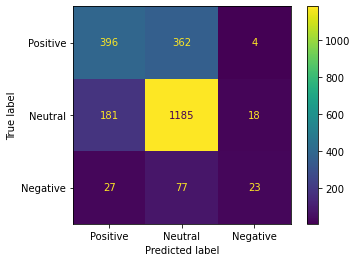

In [228]:
plot_confusion_matrix(svc_pipe,X_test,y_test,display_labels=['Positive','Neutral','Negative'])

In [223]:
svc_pipe.score(X_test,y_test)

0.7056753189617246